In [1]:
import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style = "whitegrid")

In [2]:
conn = sqlite3.connect("imdb.db")

In [3]:
tabelas = pd.read_sql_query("SELECT NAME AS 'table_name' FROM sqlite_master WHERE type = 'table'", conn)

In [4]:
tabelas = tabelas["table_name"].values.tolist()

# Qual a mediana de Avaliação dos Filmes por genero

In [5]:
display(tabelas)

['people', 'titles', 'akas', 'crew', 'episodes', 'ratings']

In [6]:
consulta3 = '''SELECT rating, genres FROM ratings JOIN titles ON ratings.title_id = titles.title_id 
WHERE premiered <= 2022 AND type = 'movie'
'''

In [7]:
resultado3 = pd.read_sql_query(consulta3, conn)

In [9]:
display(resultado3)

,rating,genres
0,4.4,\N
1,6.1,"Action,Adventure,Biography"
2,5.0,Drama
3,4.5,Drama
4,3.9,Drama
...,...,...
273289,3.5,"Action,Adventure,Thriller"
273290,5.8,Thriller
273291,6.4,"Drama,History"
273292,3.8,"Adventure,History,War"


In [8]:
def retorna_generos(df):
    df['genres'] = df['genres'].str.lower().values
    temp = df['genres'].dropna()
    vetor = CountVectorizer(token_pattern= '(?u)\\b[\\w-]+\\b', analyzer='word').fit(temp)
    generos_unicos = vetor.get_feature_names()
    generos_unicos = [genre for genre in generos_unicos if len(genre) > 1]
    return generos_unicos

In [9]:
generos_unicos = retorna_generos(resultado3)

In [10]:
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [11]:
genero_counts = []
genero_ratings = []

In [12]:
for item in generos_unicos:
    consulta = 'SELECT COUNT(rating) FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\'AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_counts.append(resultado.values[0][0])
    
    consulta = 'SELECT rating FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\'AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_ratings.append(np.median(resultado['rating']))

In [13]:
df_genero_ratings = pd.DataFrame()
df_genero_ratings['genres'] = generos_unicos
df_genero_ratings['count'] = genero_counts
df_genero_ratings['rating'] = genero_ratings

In [19]:
df_genero_ratings.head(20)

,genres,count,rating
7,documentary,40379,7.3
22,short,23,7.2
4,biography,8232,7.0
13,history,7513,6.9
24,talk-show,8,6.9
12,game-show,2,6.8
23,sport,3224,6.7
11,film-noir,762,6.6
26,war,5874,6.6
15,music,12402,6.6


In [15]:
type(df_genero_ratings)

pandas.core.frame.DataFrame

In [16]:
df_genero_ratings = df_genero_ratings.drop(index = 18)

In [18]:
df_genero_ratings = df_genero_ratings.sort_values(by = 'rating', ascending=False)

<function matplotlib.pyplot.show(close=None, block=None)>

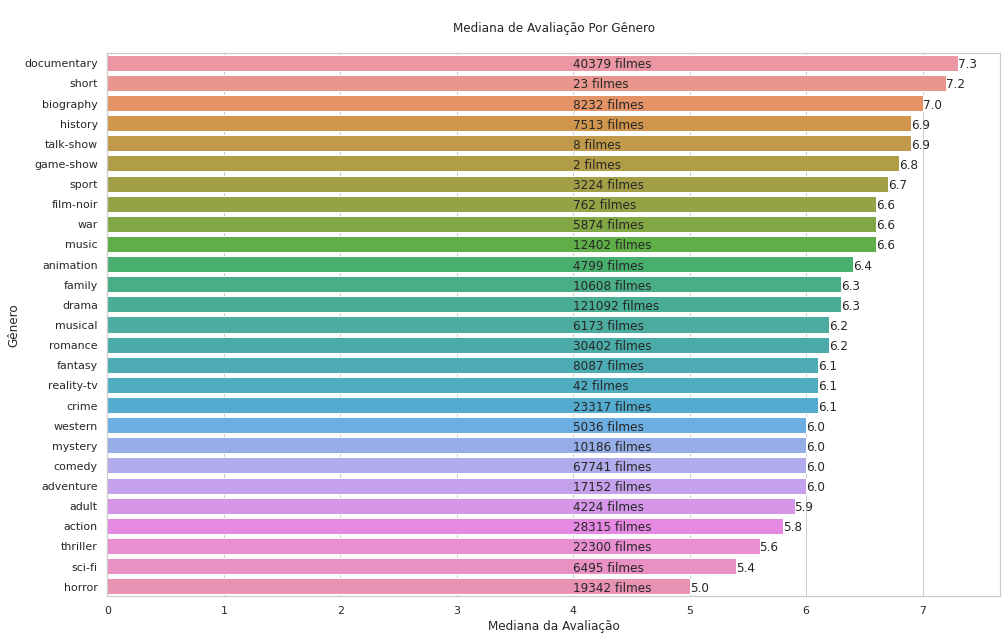

In [22]:
plt.figure(figsize=(16,10))
sns.barplot(y = df_genero_ratings.genres, x= df_genero_ratings.rating, orient='h')

for i in range(len(df_genero_ratings.index)):
    
    plt.text(4.0,
            i + 0.25,
            str(df_genero_ratings['count'][df_genero_ratings.index[i]]) + " filmes")
    
    plt.text(df_genero_ratings.rating[df_genero_ratings.index[i]],
            i + 0.25,
            round(df_genero_ratings['rating'][df_genero_ratings.index[i]], 2))
    
plt.ylabel('Gênero')
plt.xlabel('Mediana da Avaliação')
plt.title('\nMediana de Avaliação Por Gênero\n')
plt.show